In [1]:
from pyspark import SparkContext,SparkConf
from operator import add
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import re
conf = SparkConf().setAppName("review").setMaster("yarn-client")
conf.set('spark.executor.cores','2')
conf.set('spark.executor.memory','4g')
conf.set('spark.executor.instances','4')
spark = SparkSession.builder\
    .config(conf=conf) \
    .enableHiveSupport()\
    .getOrCreate()
sc=spark.sparkContext

In [4]:
sc.stop()
spark.stop()

In [ ]:
inputPath = "data/amazon/review_parquet"
reviewDf = spark.read.parquet(inputPath)
reviewDf.printSchema()
reviewDf.show(5)
reviewDf.cache()
n = reviewDf.count()

root
 |-- ui: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- summary: string (nullable = true)
 |-- text: string (nullable = true)

+--------------------+------+--------------------+--------------------+
|                  ui|rating|             summary|                text|
+--------------------+------+--------------------+--------------------+
|AFRHGK388GZ6F-096...|   5.0|If you are making...|If you are making...|
|AFRHGK388GZ6F-096...|   5.0|If you are making...|If you are making...|
|AFRHGQ3333SQ6-B00...|   3.0|  Short product date|Received product ...|
|AFRHGQ3333SQ6-B00...|   1.0|Wish I could retu...|I bought this in ...|
|AFRHH3JWCCZ60-B00...|   5.0|        Portable Cot|I ordered this to...|
+--------------------+------+--------------------+--------------------+
only showing top 5 rows



142769626 [10382721, 7368699, 12230008, 26993692, 85794506]


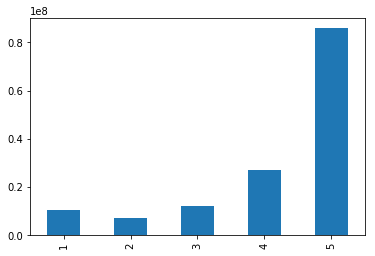

In [3]:
n1 = reviewDf.filter('rating=1.0').count()
n2 = reviewDf.filter('rating=2.0').count()
n3 = reviewDf.filter('rating=3.0').count()
n4 = reviewDf.filter('rating=4.0').count()
n5 = reviewDf.filter('rating=5.0').count()
%matplotlib inline
n_list = [n1,n2,n3,n4,n5]
print n,n_list
pd.Series([n1,n2,n3,n4,n5],index=xrange(1,6)).plot(kind='bar')

In [5]:
posDf = reviewDf.filter('rating=5.0').limit(1000000)
posDf.cache()
print posDf.count()
posDf.show(5)
navDf = reviewDf.filter('rating<=2.0').limit(1000000)
navDf.cache()
print navDf.count()
navDf.show(5)

Py4JJavaError: An error occurred while calling o88.cache.
: java.lang.NullPointerException
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$.needToCopyObjectsBeforeShuffle(ShuffleExchange.scala:159)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$.prepareShuffleDependency(ShuffleExchange.scala:243)
	at org.apache.spark.sql.execution.CollectLimitExec.doExecute(limit.scala:43)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.columnar.InMemoryRelation.buildBuffers(InMemoryRelation.scala:90)
	at org.apache.spark.sql.execution.columnar.InMemoryRelation.<init>(InMemoryRelation.scala:85)
	at org.apache.spark.sql.execution.columnar.InMemoryRelation$.apply(InMemoryRelation.scala:41)
	at org.apache.spark.sql.execution.CacheManager$$anonfun$cacheQuery$1.apply(CacheManager.scala:100)
	at org.apache.spark.sql.execution.CacheManager.writeLock(CacheManager.scala:68)
	at org.apache.spark.sql.execution.CacheManager.cacheQuery(CacheManager.scala:92)
	at org.apache.spark.sql.Dataset.persist(Dataset.scala:2502)
	at org.apache.spark.sql.Dataset.cache(Dataset.scala:2512)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [6]:
from pyspark.ml.feature import *
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
df = posDf.union(navDf)
df = df.withColumn('label',(col('rating')/5).cast(IntegerType()))
df.cache()
df.show(5)
train,test = df.randomSplit([9.0,1.0])
tokenizer = Tokenizer(inputCol="text",outputCol="words")
hashingTf =HashingTF(numFeatures=2000,inputCol="words",outputCol="features")
# wordsData = tokenizer.transform(df)
# featureizedData = hashingTf.transform(wordsData)
# idf = IDF(inputCol='rawFeatures',outputCol='features')
# idfModel = idf.fit(featureizedData)
lr =  LogisticRegression().\
      setMaxIter(10).\
      setRegParam(0.01)
pipeline = Pipeline(stages=[tokenizer,hashingTf,lr])
# pipelineModel = pipeline.fit(df)
# scaledDf = pipelineModel.transform(df)
# scaledDf.cache()
# scaledDf.printSchema()
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTf.numFeatures, [1000, 2000, 5000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.maxIter, [10,20])\
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

# scaledDf.select('ui','rating','text','label','prediction','rawPrediction').take(10)

+--------------------+------+--------------------+--------------------+-----+
|                  ui|rating|             summary|                text|label|
+--------------------+------+--------------------+--------------------+-----+
|A2OJB6YBUQEEAH-B0...|   5.0|Suction baby, suc...|So get this, they...|    1|
|A2OJB7CPIUFGZ7-B0...|   5.0|     Good Investment|As soon as I rece...|    1|
|A2OJB7EFIBUMEU-18...|   5.0|Entertaining, hum...|John Moore does a...|    1|
|A2OJB7G0NKDFXX-B0...|   5.0|       True Religion|Was a great Chris...|    1|
|A2OJB7TNAY4PRA-B0...|   5.0|  LTJ at their BEST!|I own every singl...|    1|
+--------------------+------+--------------------+--------------------+-----+
only showing top 5 rows



NameError: name 'scaledDf' is not defined

In [111]:
evator = BinaryClassificationEvaluator(labelCol='label',
                                       metricName='areaUnderROC',
                                       rawPredictionCol='rawPrediction')
result = evator.evaluate(scaledDf)
print 'acc:',result


acc: 0.94185405705
